# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je do 8. 5. 2023, 23:59:59**, pokud odevzdáte úkol do 14. 5. 2023, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **predikce labelu**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [343]:
### odtud už je to Vaše
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipyplot
import seaborn as sns
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from PIL import Image
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.utils._testing import ignore_warnings 
from sklearn.exceptions import FitFailedWarning
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA


SEED = 1
TEST_SIZE = 1/4

In [344]:
df = pd.read_csv("train.csv")
display(df.head(10))
display(df.dtypes)
display(df["label"].value_counts())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,103,0,0,0,0,0,0,0,0,0
6,0,0,0,3,0,1,1,1,1,0,...,94,46,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,42,161,...,158,160,114,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

label
1    1201
0    1199
Name: count, dtype: int64

Dataset obsahuje ***label***, který nabývá hodnot 1 a 0 a je číselnou reprezentací kusu oděvu. 0 jsou trika/topy a 1 jsou kalhoty. Počet trik a kalhot je vyvážený, takže se nemusíme při vyhodnocování příliš starat o poměr trik a kalhot. Zbylé sloupce reprezentují jednotlivé pixely a nabývají hodnot 0 až 255, což jsou stupně šedi.

***Label*** si převedu na kategorickou reprezentaci a na jednotlivé ***pixely*** mi bude stačit uint8.
 

In [345]:
df["label"] = df["label"].astype("category")
cols = df.columns[df.dtypes.eq('int64')]
df[cols] = df[cols].astype("uint8")

Pár obrázků si zobrazím ve zvětšené podobě.

In [346]:
def to_image(arr: pd.Series):
    return Image.fromarray(arr.to_numpy(dtype=np.uint8).reshape(28,28), mode="L")
def to_image_df(arr: pd.Series):
    return Image.fromarray(arr[1:].to_numpy(dtype=np.uint8).reshape(28,28), mode="L")

images = []
image_cnt = 60
for i in range(image_cnt):
    images.append(to_image_df(df.iloc[i]))

ipyplot.plot_images(images, max_images=image_cnt, img_width=75)

/home/daniel/School/ML2/BI-ML2-2023-rileydan/ml2/lib/python3.8/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))


Na obrázcích lze vidět, že jsou v negativu. To nám ale nevadí a můžeme je tak ponechat.

Nemuselo by být na škodu si vytvořit další atribut - velikost pozadí - ***bg***. 

/tmp/ipykernel_16274/1726036397.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["bg"] = df.apply(bg, axis=1)


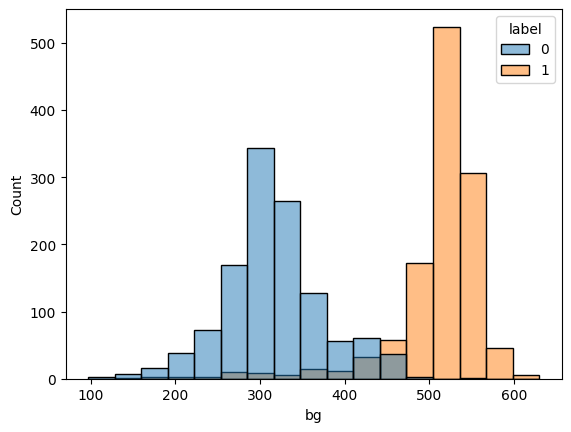

In [347]:
def bg(row: pd.Series):
    return row[1:].value_counts()[0]

df["bg"] = df.apply(bg, axis=1)


sns.histplot(data=df, hue="label", x='bg')
plt.show()

Obrázky s kalhotami(**1**) mají o dost větší plochu pozadí(***bg***) oproti trikům(**0**), jelikož jsou delší jak trika a na obrázcích se poté jeví užší, zatímco trika zabírají více plochy do šířky. Díky tomu by mohla velká část obrazků být snadno oddělitelná právě pomocí hodnot pixelů, které jsou v místech, kde trika mívají kraje a rukávy a kde mají kalhoty mezeru mezi nohavicemi. Tento atribut tedy záměrně vynechám, myslím si že jde proti smyslu úlohy, ale přišlo mi dobré ho alespoň použít k získání informací o datasetu.

Data si rozdělím na trénovací a testovací množinu. Nad trénovacími daty budu tedy provádět křížovou validaci.

In [348]:
df.drop(columns=["bg"], inplace=True)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(
    df.drop(columns=["label"]),
    df["label"],
    test_size=TEST_SIZE,
    random_state=SEED
)

Postupně zkusím všechny metody. Začnu s SVM. Také budu zkoušet standardizaci a normalizaci dat. Obě metody by měly pomoci modelům detekovat jemnější rozdíly u jednotlivých kusů oblečení. Standardizace jednotlivé atributy naškáluje tak, že budou mít střední hodnotu v nule a jednotný rozptyl. To může pomoci zvýraznit rozdíly u pixelů, které se v šedosti liší nepatrně, ale může to mít velký dopad. Toto mi ale přijde nepravděpodobné a spíš si myslím, že se může hodit normalizovat jednotlivé obrázky - každý obrázek se normalizuje a povede to k tomu, že tmavé kusy oblčení nebudou již tak odlišné od světlých. 

### SVM

SVM slouží k nalezení rozhodovací hranice takové, že ze všech hranic má největší odstup od nejbližšího bodu. V našem případě budou pravděpodobně obrázky kvůli malé skupině zvláštních kusů lineárně neseparabilní. Špatně klasifikované body budou penalizovány, takže budeme chtít vyzkoušet kolik špatně klasifikovaných bodů budeme ochotni tolerovat. K tomu využijeme parameter C. Čím je vyšší tím více modelu bráníme v přehlížení špatně klasifikovaných bodů. Dále si také vyzkouším různé jádrové funkce, které nám transformují příznakový prostor a umožňují nám hledat nelineární vztahy v modelu.

In [349]:
pipeline = Pipeline(
    [
        ("scaling", "passthrough"),
        ("svm", SVC()) 
    ]
)

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "svm__C": np.logspace(-4,4,10),
    "svm__kernel": ["linear", "poly", "rbf"]
}

grid_search_svm = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

grid_search_svm.fit(train_data, train_target)
print(grid_search_svm.best_params_)
print(grid_search_svm.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'scaling': Normalizer(), 'svm__C': 21.54434690031882, 'svm__kernel': 'poly'}
0.9883333333333333


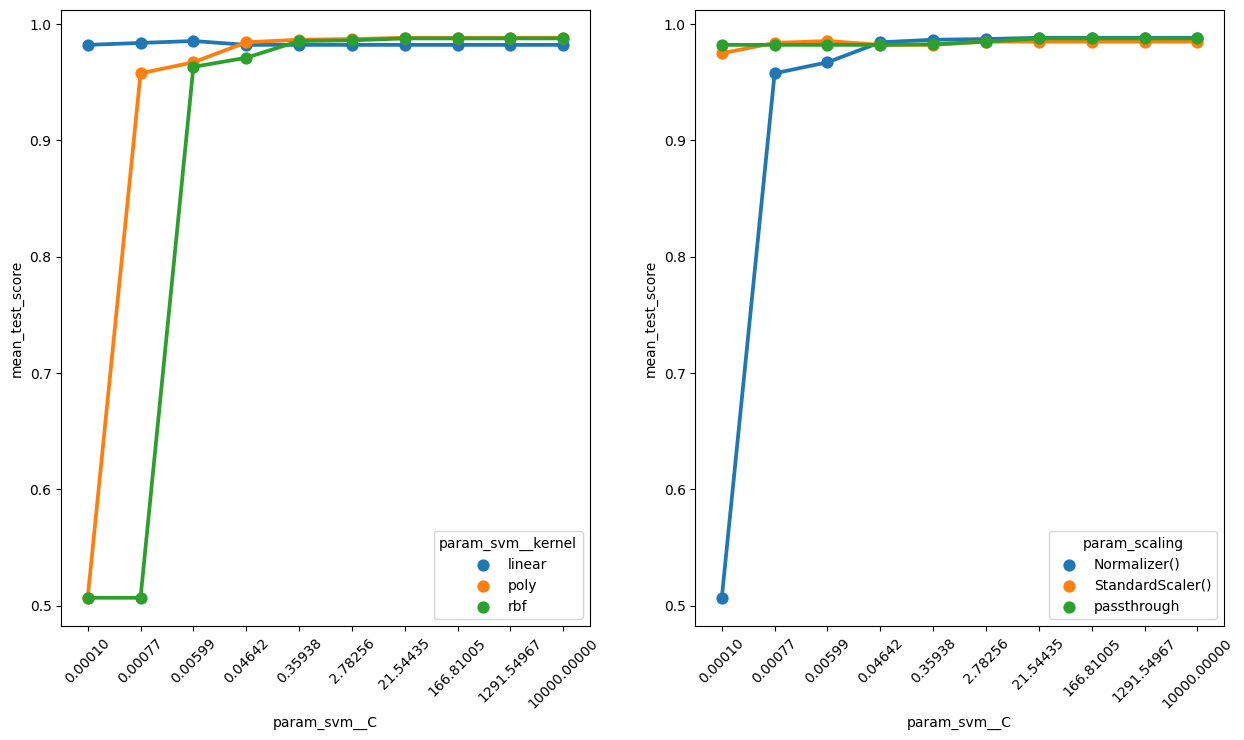

In [350]:
svm_results = pd.DataFrame(grid_search_svm.cv_results_)

fig, ax = plt.subplots(ncols=2, figsize=(15,8))

svm_results_C_kernel = svm_results.groupby(['param_svm__kernel', 'param_svm__C'])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[0], x="param_svm__C", y="mean_test_score", hue="param_svm__kernel", data=svm_results_C_kernel, errorbar=None)
xticks = ax[0].get_xticklabels()
xlabels = ['{:.5f}'.format(float(x.get_text())) for x in xticks]
ax[0].set_xticklabels(xlabels, rotation=45)

svm_results["param_scaling"] = svm_results["param_scaling"].astype("str")
svm_results_C_scaling = svm_results.groupby(["param_svm__C", "param_scaling"])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[1], x="param_svm__C", y="mean_test_score", hue="param_scaling", data=svm_results_C_scaling, errorbar=None)
xticks = ax[1].get_xticklabels()
xlabels = ['{:.5f}'.format(float(x.get_text())) for x in xticks]
ax[1].set_xticklabels(xlabels, rotation=45)
plt.show()

Model odhadl správně v průměru téměř 99% obrázků trénovacího datasetu. Jádra se výsledkově příliš nelišily, takže mezi obrázky pravděpodobně existuje lineární závislost, která asi bude spočívat v ploše pozadí o které jsem mluvil výše. Nahrává tomu i srovnání škálování dat, které je má v podstatě shodné výsledky jako data bez škálování, což nahrává tomu, že rozdíly byly hlavně v místech, kde již jsou pixely dostatečně odlišné.

### Naive Bayes

Naivní Bayes je přístup, kdy se snažíme vykonstruovat model pro odhad podmíněné pravěpodobnosti P(X = x|Y = y). Tímto odhadneme rozdělení, ze kterého se data tvořila a jsme pomocí něj schopni generovat nová data. Naivní Bayesův klasifikátor předpokládá, že pro konkrétní hodnotu cílové proměnné předpokládáme nezavislost příznaků, tedy pixelů. Tento předpoklad je v tomto případě dosti mylný. Pokud si vezmu např. kalhoty, tak barva nějakého pixelu má jistě vliv na ostaní, sousední pixely budou podobně barevné, odlehlejší pixely budou černé, protože jsou pozadí. Ačkoli tento předpoklad zjevně porušujeme, tak může bayesův klasifikátor přesto mít slušné výsldky. Hodnoty pixelů mi přijde přirozenější vnímat jako spojité hodnoty a použiji tedy jako model gaussovo rozdělení. Budu zkoušet hyperparametr *var_smoothing*, který slouží k umělému navýšení rozptylu normálního rozdělení, címž pak model více vnímá odlehlé hodnoty.

In [351]:
pipeline = Pipeline(
    [
        ("scaling", "passthrough"),
        ("gnb", GaussianNB()) 
    ]
)

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "gnb__var_smoothing": np.logspace(-10,5, num=30)
}

grid_search_gnb = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

grid_search_gnb.fit(train_data, train_target)
print(grid_search_gnb.best_params_)
print(grid_search_gnb.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'gnb__var_smoothing': 7.278953843983161, 'scaling': Normalizer()}
0.9605555555555556


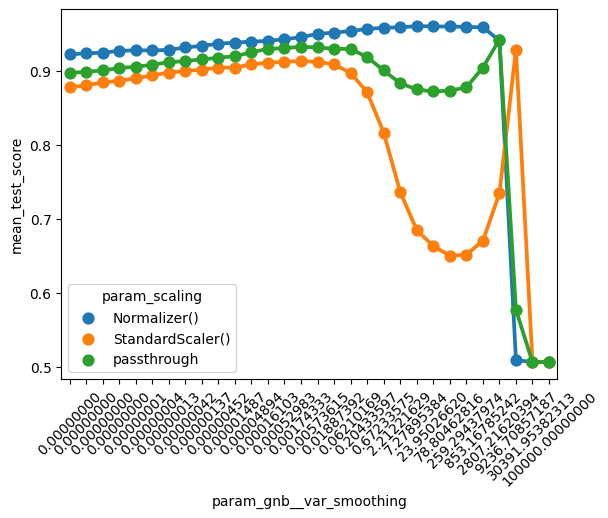

In [352]:
gnb_results = pd.DataFrame(grid_search_gnb.cv_results_)

gnb_results["param_scaling"] = gnb_results["param_scaling"].astype("str")
gnb_results = gnb_results.groupby(['param_scaling', 'param_gnb__var_smoothing'])["mean_test_score"].max().reset_index()
p = sns.pointplot(x="param_gnb__var_smoothing", y="mean_test_score", hue="param_scaling", data=gnb_results, errorbar=None)
xticks = p.get_xticklabels()
xlabels = ['{:.8f}'.format(float(x.get_text())) for x in xticks]
p.set_xticklabels(xlabels, rotation=45)
plt.show()

Model překvapivě dosáhl výsledku kolem 96% správně předpovězených obrázků, ale není tak dobrý jako SVM. Vyhlazování rozdělení trochu pomohlo, model byl schopen rozpoznat i zvláštnější kusy oblečení. Přílišné vyhlazení ale způsobilo úplné narovnání rozdělení a v důsledku nefunkčnost modelu. Mezi druhy škálování nebyl moc velký rozdíl.

### LDA

LDA je ze skupiny diskriminatiních klasifikátorů a odhadujeme P(Y = y|X = x). Využívá se ve stejných případech jako logistická regrese pro nalezení rozhodovací hranice. Pokud v našich datech existuje lineární vztah, měla by LDA dosáhnout dobrých výsledků. Vyzkouším také různé solvery a parametr *shrinkage*, který pomáhá lépe odhadnout varianční matice a předchází přetrénování.

In [353]:
pipeline = Pipeline([
    ("scaling", "passthrough"),
    ("lda", LinearDiscriminantAnalysis())
])

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "lda__solver": ['svd', 'lsqr', 'eigen'],
    "lda__shrinkage": ["auto", None]
}

grid_search_lda = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

with ignore_warnings(category=FitFailedWarning):
    grid_search_lda.fit(train_data, train_target)

print(grid_search_lda.best_params_)
print(grid_search_lda.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/daniel/School/ML2/BI-ML2-2023-rileydan/ml2/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.98222222 0.97888889 0.98333333
 0.98222222 0.97888889 0.98333333 0.91833333 0.93       0.91833333
 0.91722222 0.92944444 0.91722222        nan        nan        nan]
  warnings.warn(


{'lda__shrinkage': 'auto', 'lda__solver': 'lsqr', 'scaling': StandardScaler()}
0.9833333333333334


In [354]:
lda_results = pd.DataFrame(grid_search_lda.cv_results_)
lda_results = lda_results[lda_results["mean_test_score"].notna()]
lda_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lda__shrinkage,param_lda__solver,param_scaling,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.456471,0.298409,0.041041,0.004856,auto,lsqr,passthrough,"{'lda__shrinkage': 'auto', 'lda__solver': 'lsq...",0.983333,0.986111,0.988889,0.975000,0.977778,0.982222,0.005152,3
4,1.682133,0.125319,0.041851,0.003293,auto,lsqr,Normalizer(),"{'lda__shrinkage': 'auto', 'lda__solver': 'lsq...",0.969444,0.983333,0.991667,0.972222,0.977778,0.978889,0.007974,5
5,1.728581,0.067638,0.045169,0.005186,auto,lsqr,StandardScaler(),"{'lda__shrinkage': 'auto', 'lda__solver': 'lsq...",0.983333,0.988889,0.988889,0.972222,0.983333,0.983333,0.006086,1
6,1.835553,0.212547,0.048178,0.016895,auto,eigen,passthrough,"{'lda__shrinkage': 'auto', 'lda__solver': 'eig...",0.983333,0.986111,0.988889,0.975000,0.977778,0.982222,0.005152,3
7,1.847397,0.097752,0.043803,0.001797,auto,eigen,Normalizer(),"{'lda__shrinkage': 'auto', 'lda__solver': 'eig...",0.969444,0.983333,0.991667,0.972222,0.977778,0.978889,0.007974,5
8,2.110029,0.219418,0.056027,0.004288,auto,eigen,StandardScaler(),"{'lda__shrinkage': 'auto', 'lda__solver': 'eig...",0.983333,0.988889,0.988889,0.972222,0.983333,0.983333,0.006086,1
9,2.183052,0.149375,0.046398,0.004946,None,svd,passthrough,"{'lda__shrinkage': None, 'lda__solver': 'svd',...",0.905556,0.897222,0.913889,0.925000,0.950000,0.918333,0.018308,9
10,2.358724,0.104753,0.052169,0.008950,None,svd,Normalizer(),"{'lda__shrinkage': None, 'lda__solver': 'svd',...",0.933333,0.925000,0.916667,0.930556,0.944444,0.930000,0.009196,7
11,2.258573,0.267832,0.063060,0.011766,None,svd,StandardScaler(),"{'lda__shrinkage': None, 'lda__solver': 'svd',...",0.905556,0.897222,0.913889,0.925000,0.950000,0.918333,0.018308,9
12,1.309837,0.141137,0.039452,0.003358,None,lsqr,passthrough,"{'lda__shrinkage': None, 'lda__solver': 'lsqr'...",0.913889,0.900000,0.911111,0.911111,0.950000,0.917222,0.017069,11


Model správně předpověděl druh oblečení u zhruba 98% obrázků, což potvrzuje lineární vztah mezi většinou obrázků. Pomohla také automatická regularizace, která vedla k lepším validačním výsledkům. U škálování opět nebyly výrazné rozdíly.

# LLE

LLE je metoda pro redukci dimenze dat spadající pod manifold learning, kde je smyslem modelů hledání a zachování lokálních vztahů. LLE hledá lineární závislosti bodů na svém okolí a poté se je pokouší zachovat v méně dimenzionální reprezentaci. Vzhledem k výsledkům výše očekávám, že by metoda mohla pomoci, ale myslím si, že PCA bude lepší, vzhledem k tomu, že se obrázky od sebe liší většinou ve stejných pixelech a existují tedy globální vztahy mezi příznaky.

### SVM

In [372]:
pipeline = Pipeline(
    [
        ("scaling", "passthrough"),
        ("lle", LocallyLinearEmbedding()),
        ("svm", SVC(C=10)) 
    ]
)

params = {
    "lle__n_components": range(1,40,2),
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "svm__kernel": ["linear", "poly", "rbf"]
}

grid_search_svm_lle = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

grid_search_svm_lle.fit(train_data, train_target)
print(grid_search_svm_lle.best_params_)
print(grid_search_svm_lle.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'lle__n_components': 7, 'scaling': Normalizer(), 'svm__kernel': 'rbf'}
0.9916666666666668


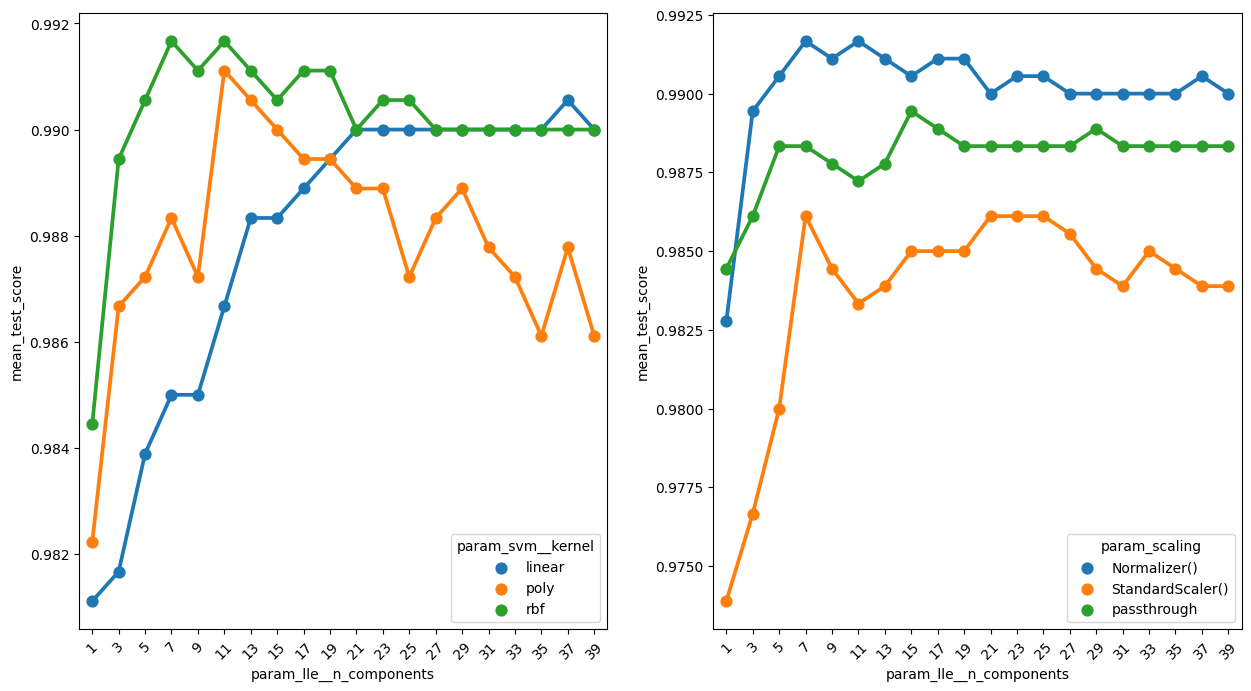

In [374]:
svm_results_lle = pd.DataFrame(grid_search_svm_lle.cv_results_)

fig, ax = plt.subplots(ncols=2, figsize=(15,8))

svm_results_lle_n_components_kernel = svm_results_lle.groupby(['param_svm__kernel', 'param_lle__n_components'])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[0], x="param_lle__n_components", y="mean_test_score", hue="param_svm__kernel", data=svm_results_lle_n_components_kernel, errorbar=None)
xticks = ax[0].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[0].set_xticklabels(xlabels, rotation=45)

svm_results_lle["param_scaling"] = svm_results_lle["param_scaling"].astype("str")
svm_results_lle_n_components_scaling = svm_results_lle.groupby(["param_lle__n_components", "param_scaling"])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[1], x="param_lle__n_components", y="mean_test_score", hue="param_scaling", data=svm_results_lle_n_components_scaling, errorbar=None)
xticks = ax[1].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[1].set_xticklabels(xlabels, rotation=45)
plt.show()

### Naive Bayes

In [357]:
pipeline = Pipeline(
    [
        ("scaling", "passthrough"),
        ("lle", LocallyLinearEmbedding()),
        ("gnb", GaussianNB()) 
    ]
)

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "lle__n_components": range(1,40,2)
}

grid_search_gnb_lle = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

grid_search_gnb_lle.fit(train_data, train_target)
print(grid_search_gnb_lle.best_params_)
print(grid_search_gnb_lle.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'lle__n_components': 17, 'scaling': 'passthrough'}
0.9894444444444446


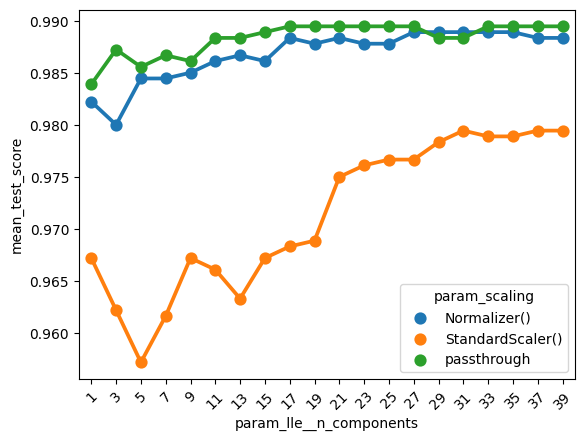

In [358]:
gnb_results_lle = pd.DataFrame(grid_search_gnb_lle.cv_results_)

gnb_results_lle["param_scaling"] = gnb_results_lle["param_scaling"].astype("str")
gnb_results_lle_n_components_scaling = gnb_results_lle.groupby(['param_scaling', 'param_lle__n_components'])["mean_test_score"].max().reset_index()
p = sns.pointplot(x="param_lle__n_components", y="mean_test_score", hue="param_scaling", data=gnb_results_lle_n_components_scaling, errorbar=None)
xticks = p.get_xticklabels()
xlabels = [x.get_text() for x in xticks]
p.set_xticklabels(xlabels, rotation=45)
plt.show()

### LDA

In [359]:
pipeline = Pipeline([
    ("scaling", "passthrough"),
    ("lle", LocallyLinearEmbedding()),
    ("lda", LinearDiscriminantAnalysis(shrinkage="auto"))
])

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "lle__n_components": range(1,40,2),
    "lda__solver": ['lsqr', 'eigen'],
}

grid_search_lda_lle = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

with ignore_warnings(category=FitFailedWarning):
    grid_search_lda_lle.fit(train_data, train_target)

print(grid_search_lda_lle.best_params_)
print(grid_search_lda_lle.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'lda__solver': 'lsqr', 'lle__n_components': 17, 'scaling': Normalizer()}
0.9894444444444446


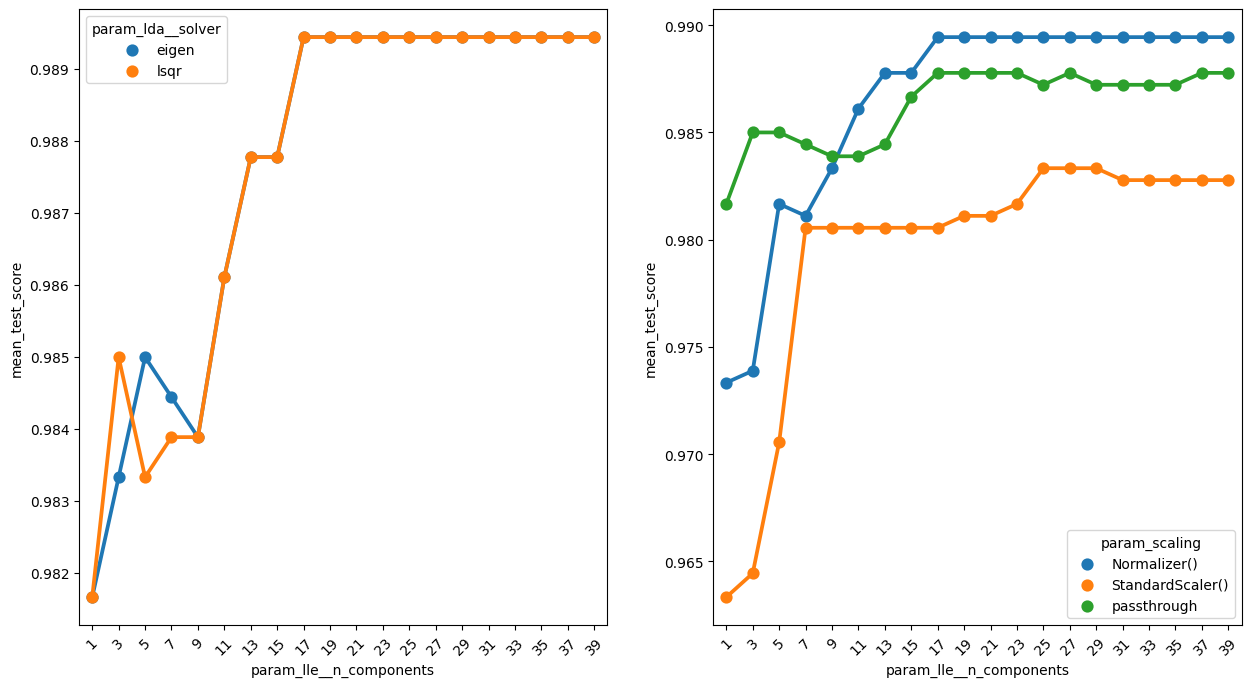

In [360]:
lda_results_lle = pd.DataFrame(grid_search_lda_lle.cv_results_)

fig, ax = plt.subplots(ncols=2, figsize=(15,8))

lda_results_lle_n_components_kernel = lda_results_lle.groupby(['param_lda__solver', 'param_lle__n_components'])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[0], x="param_lle__n_components", y="mean_test_score", hue="param_lda__solver", data=lda_results_lle_n_components_kernel, errorbar=None)
xticks = ax[0].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[0].set_xticklabels(xlabels, rotation=45)

lda_results_lle["param_scaling"] = lda_results_lle["param_scaling"].astype("str")
lda_results_lle_n_components_scaling = lda_results_lle.groupby(["param_lle__n_components", "param_scaling"])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[1], x="param_lle__n_components", y="mean_test_score", hue="param_scaling", data=lda_results_lle_n_components_scaling, errorbar=None)
xticks = ax[1].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[1].set_xticklabels(xlabels, rotation=45)
plt.show()

Redukce dimenzionality nám očividně pomohla - modely pravděpodobně nejsou tolik přetrénovány a jejich odhady jsou obecnější. U všech modelů je patrně horší standardizace dat, což by mohlo být způsobeno tím, že normalizace lépe pomůže zvýraznit rozdíly v pixelech tím, že je aplikovaná na jednotlivé obrázky jak jsem již zmiňoval výše. Projevilo se to až po zobecnění dat, kdy jsou výraznější rozdíly mezi důležitými pixely důležitější.  

# PCA

Jak již bylo zmíněno výše, PCA hledá hlavní komponenty na základě globálních souvislostí v datech. Je potřeba aby tyto vztahy byly lineární, jelikož počítáme výběrovou varianční matici, ve které bychom složitější vztahy neodhalili. Hlavní komponenty odpovídají směrům ve kterých mají data největší rozptyl.

### SVM

In [361]:
pipeline = Pipeline(
    [
        ("scaling", "passthrough"),
        ("pca", PCA()),
        ("svm", SVC(C=10)) 
    ]
)

params = {
    "scaling": [Normalizer(), StandardScaler()],
    "pca__n_components": range(1,40,2),
    "svm__kernel": ["poly", "rbf", "linear"]
}

grid_search_svm_pca = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

grid_search_svm_pca.fit(train_data, train_target)
print(grid_search_svm_pca.best_params_)
print(grid_search_svm_pca.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'pca__n_components': 11, 'scaling': Normalizer(), 'svm__kernel': 'rbf'}
0.993888888888889


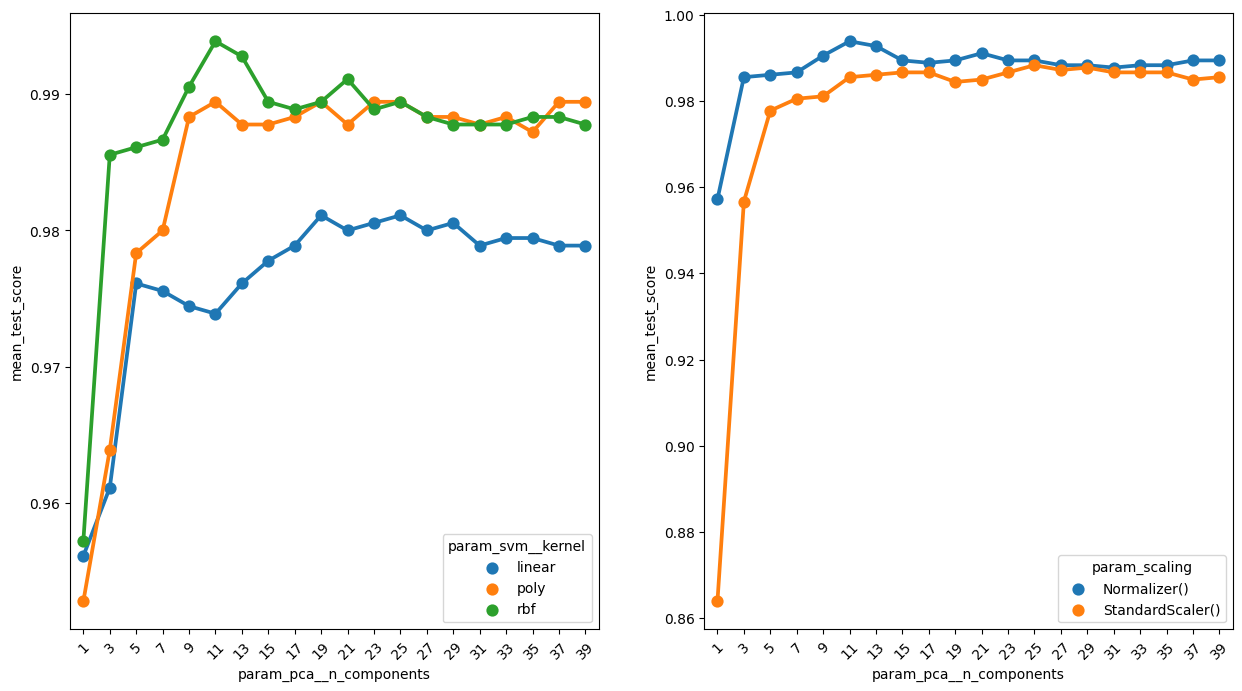

In [362]:
svm_results_pca = pd.DataFrame(grid_search_svm_pca.cv_results_)

fig, ax = plt.subplots(ncols=2, figsize=(15,8))

svm_results_pca_n_components_kernel = svm_results_pca.groupby(['param_svm__kernel', 'param_pca__n_components'])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[0], x="param_pca__n_components", y="mean_test_score", hue="param_svm__kernel", data=svm_results_pca_n_components_kernel, errorbar=None)
xticks = ax[0].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[0].set_xticklabels(xlabels, rotation=45)

svm_results_pca["param_scaling"] = svm_results_pca["param_scaling"].astype("str")
svm_results_pca_n_components_scaling = svm_results_pca.groupby(["param_pca__n_components", "param_scaling"])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[1], x="param_pca__n_components", y="mean_test_score", hue="param_scaling", data=svm_results_pca_n_components_scaling, errorbar=None)
xticks = ax[1].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[1].set_xticklabels(xlabels, rotation=45)
plt.show()

### Naive Bayes 

In [363]:
pipeline = Pipeline(
    [
        ("scaling", "passthrough"),
        ("pca", PCA()),
        ("gnb", GaussianNB(var_smoothing=0.001)) 
    ]
)

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "pca__n_components": range(1,40,2)
}

grid_search_gnb_pca = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

grid_search_gnb_pca.fit(train_data, train_target)
print(grid_search_gnb_pca.best_params_)
print(grid_search_gnb_pca.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'pca__n_components': 17, 'scaling': 'passthrough'}
0.982777777777778


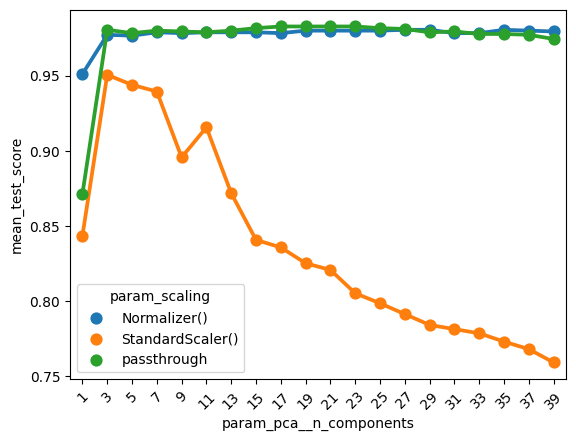

In [364]:
gnb_results_pca = pd.DataFrame(grid_search_gnb_pca.cv_results_)

gnb_results_pca["param_scaling"] = gnb_results_pca["param_scaling"].astype("str")
gnb_results_pca_n_components_scaling = gnb_results_pca.groupby(['param_scaling', 'param_pca__n_components'])["mean_test_score"].max().reset_index()
p = sns.pointplot(x="param_pca__n_components", y="mean_test_score", hue="param_scaling", data=gnb_results_pca_n_components_scaling, errorbar=None)
xticks = p.get_xticklabels()
xlabels = [x.get_text() for x in xticks]
p.set_xticklabels(xlabels, rotation=45)
plt.show()

### LDA

In [365]:
pipeline = Pipeline([
    ("scaling", "passthrough"),
    ("pca", PCA()),
    ("lda", LinearDiscriminantAnalysis(shrinkage="auto"))
])

params = {
    "scaling": ["passthrough", Normalizer(), StandardScaler()],
    "pca__n_components": range(1,40,2),
    "lda__solver": ['lsqr', 'eigen'],
}

grid_search_lda_pca = GridSearchCV(
    pipeline,
    params,
    n_jobs=-1,
    cv=5,
    verbose=True
  )

with ignore_warnings(category=FitFailedWarning):
    grid_search_lda_pca.fit(train_data, train_target)

print(grid_search_lda_pca.best_params_)
print(grid_search_lda_pca.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
{'lda__solver': 'lsqr', 'pca__n_components': 35, 'scaling': 'passthrough'}
0.9866666666666667


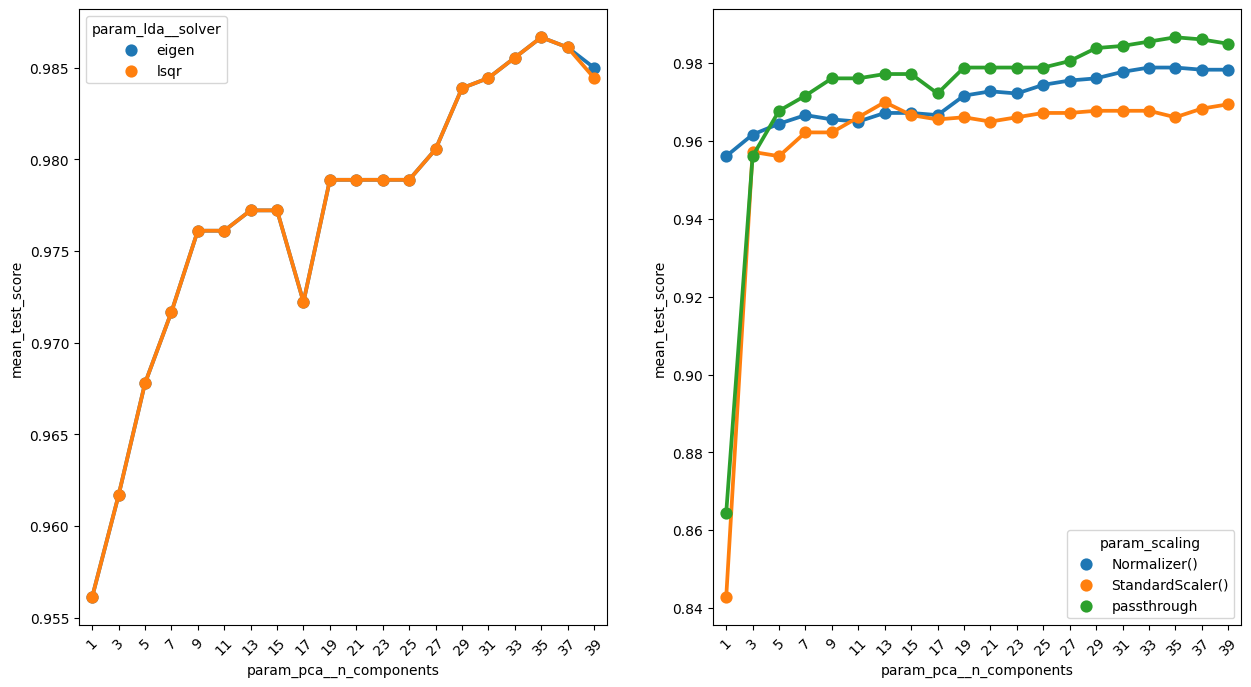

In [366]:
lda_results_pca = pd.DataFrame(grid_search_lda_pca.cv_results_)

fig, ax = plt.subplots(ncols=2, figsize=(15,8))

lda_results_pca_n_components_kernel = lda_results_pca.groupby(['param_lda__solver', 'param_pca__n_components'])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[0], x="param_pca__n_components", y="mean_test_score", hue="param_lda__solver", data=lda_results_pca_n_components_kernel, errorbar=None)
xticks = ax[0].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[0].set_xticklabels(xlabels, rotation=45)

lda_results_pca["param_scaling"] = lda_results_pca["param_scaling"].astype("str")
lda_results_pca_n_components_scaling = lda_results_pca.groupby(["param_pca__n_components", "param_scaling"])["mean_test_score"].max().reset_index()
sns.pointplot(ax=ax[1], x="param_pca__n_components", y="mean_test_score", hue="param_scaling", data=lda_results_pca_n_components_scaling, errorbar=None)
xticks = ax[1].get_xticklabels()
xlabels = [x.get_text() for x in xticks]
ax[1].set_xticklabels(xlabels, rotation=45)
plt.show()

PCA opravdu vyšlo o trochu lépe než LLE a použiji ho pro finální model v kombinace s SVM.

# Finální model a vyhodnocení

Nejlepších výsledků jsem dosahoval po normalizaci dat a dává mi také nejvíce smysl, proto jí využiji. Pro redukci dimenzionality zvolím PCA s 11 hlavními komponentami a jako klasifikátor použiji SVM.

In [367]:
final_pipeline = Pipeline(
    [
        ("scaling", Normalizer()),
        ("pca", PCA(n_components=11)),
        ("svm", SVC(C=10)) 
    ]
)

final_pipeline.fit(train_data, train_target)
final_pipeline.score(test_data, test_target)

0.9783333333333334

Výsledná přesnost modelu na testovacích datech je téměř 98 procent, takže by model na nových datech měl dosahovat přibližně této přesnosti.

In [368]:
norm_data = Normalizer().fit_transform(train_data)
pca = PCA(n_components=11)
pca.fit_transform(norm_data)
# uryvek kodu z notebooku cv. 04
for i, explained_variance_ratio in enumerate(pca.explained_variance_):
    print(f"Rozptyl vysvětlený {i + 1}. hlavní komponentou: {explained_variance_ratio:.2f},\tPodíl z celku: {pca.explained_variance_ratio_[i]:.2f},\tKumulovaný podíl z celku: {pca.explained_variance_ratio_[0:i+1].sum():.2f}")

Rozptyl vysvětlený 1. hlavní komponentou: 0.08,	Podíl z celku: 0.34,	Kumulovaný podíl z celku: 0.34
Rozptyl vysvětlený 2. hlavní komponentou: 0.02,	Podíl z celku: 0.07,	Kumulovaný podíl z celku: 0.41
Rozptyl vysvětlený 3. hlavní komponentou: 0.01,	Podíl z celku: 0.05,	Kumulovaný podíl z celku: 0.45
Rozptyl vysvětlený 4. hlavní komponentou: 0.01,	Podíl z celku: 0.04,	Kumulovaný podíl z celku: 0.50
Rozptyl vysvětlený 5. hlavní komponentou: 0.01,	Podíl z celku: 0.04,	Kumulovaný podíl z celku: 0.54
Rozptyl vysvětlený 6. hlavní komponentou: 0.01,	Podíl z celku: 0.03,	Kumulovaný podíl z celku: 0.56
Rozptyl vysvětlený 7. hlavní komponentou: 0.01,	Podíl z celku: 0.02,	Kumulovaný podíl z celku: 0.58
Rozptyl vysvětlený 8. hlavní komponentou: 0.00,	Podíl z celku: 0.02,	Kumulovaný podíl z celku: 0.60
Rozptyl vysvětlený 9. hlavní komponentou: 0.00,	Podíl z celku: 0.02,	Kumulovaný podíl z celku: 0.62
Rozptyl vysvětlený 10. hlavní komponentou: 0.00,	Podíl z celku: 0.01,	Kumulovaný podíl z celku: 0.63

U PCA jsem pravděpodobně zvolil trochu větší počet komponent, než by bylo potřeba, od 6./7. komponenty už jednotlivé komponenty mají opravdu malý vliv a můj model by mohl být lehce přetrénovaný.

In [369]:
results = final_pipeline.predict(test_data)
test_results = test_data.copy()
test_results["label"] = test_target
test_results["result"] = results

misclassified_images = test_results[test_results["label"] != test_results["result"]]

In [370]:
images_mis = []
image_cnt_mis = misclassified_images.shape[0]
for index, row in misclassified_images.iterrows():
    images_mis.append(to_image(row[:784]))

ipyplot.plot_images(images_mis, max_images=image_cnt_mis, img_width=75)

/home/daniel/School/ML2/BI-ML2-2023-rileydan/ml2/lib/python3.8/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))


Z špatně klasifikovaných obrázků je vidět, že model měl problém hlavně s zvláštně tvarovanými kusy oděvů, které od ostatních vybočují. Na testovacích datech se ukázalo, že si s velkou většinou obrázků model poradí.

In [371]:
evaluate_data = pd.read_csv("evaluate.csv")
evaluate_result = pd.DataFrame()
evaluate_result["ID"] = evaluate_data["ID"]
evaluate_result["label"] = final_pipeline.predict(evaluate_data.drop(columns=["ID"]))
evaluate_result.to_csv("results.csv", index=False)